<a href="https://colab.research.google.com/github/cristianocapone/RL_ML_class/blob/main/code.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Observation Space: Box(-inf, inf, (27,), float64)
Action Space: Box(-1.0, 1.0, (8,), float32)


100%|██████████| 5000/5000 [07:36<00:00, 10.96it/s]


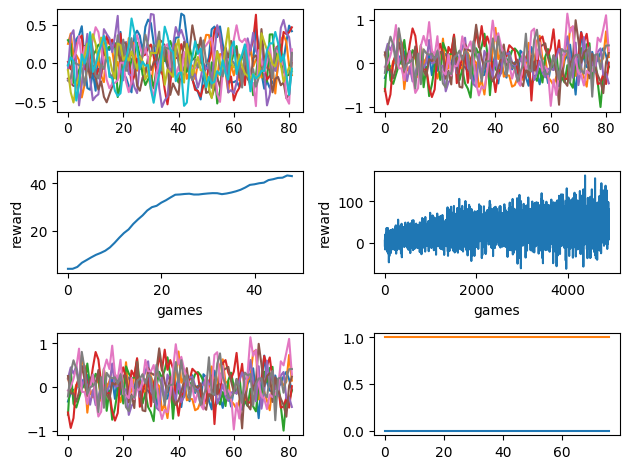

In [21]:
import gymnasium as gym
import numpy as np
import network as net

from optimizer import Adam
import matplotlib.pyplot as plt
import pickle
from copy import deepcopy
from tqdm import trange
from matplotlib.animation import ArtistAnimation
from sklearn.decomposition import PCA


plt.rcParams['animation.html'] = 'jshtml'

# Create the environment using MuJoCo's Ant environment
env = gym.make('Ant-v4')

print(f'Observation Space: {env.observation_space}')
print(f'Action Space: {env.action_space}')

render_every = 100000
n_episodes= 5000
# Parameters
if_load = False
act_variance =  0.25
episode_duration = 100

out_dim=8


N, I, O, T = 500, 27 , out_dim, 100
shape = (N, I, O, T)

dt = 0.001
tau_m = 5. * dt
tau_s = 2. * dt
tau_ro = 3. * dt
beta_s = np.exp(-dt / tau_s)
beta_ro = np.exp(-dt / tau_ro)
sigma_teach = 5.0
sigma_input = .01
sigma_output = 0.01
offT = 1
dv = 1 / 5.
alpha = 0.5
alpha_rout = 0.0005
alpha_pg = 0.0005
Vo = 0.
h = 0.
s_inh = 20

# Simulation parameters
par = {'tau_m': tau_m, 'tau_s': tau_s, 'tau_ro': tau_ro, 'beta_ro': beta_ro,
       'dv': dv, 'alpha': alpha, 'Vo': Vo, 'h': h, 's_inh': s_inh,
       'N': N, 'T': T, 'dt': dt, 'offT': offT, 'alpha_rout': alpha_rout,
       'sigma_input': sigma_input, 'sigma_teach': sigma_teach, 'shape': shape, 'sigma_output': sigma_output}

par['sigma_rec'] = .95/np.sqrt(N)

n_repeats = 1

for repeats in range(n_repeats):

    network = net.GOAL_GRADED(par)

    if if_load:
        with open('transfer.pickle', 'rb') as f:
            network = pickle.load(f)

    network.adam_out = Adam(alpha=0.0001, drop=0.99, drop_time=10000)
    network.gamma = 0.99

    network.out_dim=out_dim

    # Main loop
    REWARDS = []
    R_AVG = []

    n_movie = 0

    for iterations in trange(n_episodes):

        last_avg_reward = 0

        if_render = (iterations % render_every == 0) and (iterations > 0)
        env.reset()

        frames = []
        S = []

        obs, r, done, _, _ = env.step(np.zeros(8,))
        r_tot = 0

        if if_render:
            fig, ax = plt.subplots(figsize=(4, 5))
            ax.axis('off')
            fig.patch.set_alpha(0.)
            fig.tight_layout()

        network.reset()
        collections = dict(pred_values=[], rewards=[], a=[],action=[],musub1=[],musub2=[])

        for k in range(episode_duration):

            network.step_(obs,if_tanh=True)
            network.policy()
            obs, r, done, _, _ = env.step(network.action)

            r = np.copy(obs[13])
            r_tot += r

            network.learn_error(r-last_avg_reward*0)

            collections['pred_values'].append(network.value)
            collections['rewards'].append(r)
            collections['action'].append(network.action)

            S.append(network.S)

            if done:
                break

            if if_render:
                IMG = env.render()
                frames += [(ax.imshow (IMG),)]

        REWARDS.append(r_tot)

        if (iterations % 1 == 0) and (iterations > 0):
            network.update_J(l2_out=0.)

        if (iterations % 100 == 0) and (iterations > 0):

            last_avg_reward = np.mean(REWARDS[-1000:])
            R_AVG.append(np.mean(REWARDS[-1000:]))

            plt.figure(0)
            plt.clf()
            plt.subplot(321)
            plt.plot(np.array(S).T[:10,:].T)#, aspect='auto',cmap='gray')

            plt.subplot(322)
            plt.plot(collections['action'])

            plt.subplot(323)
            plt.plot(R_AVG)
            plt.xlabel('games')
            plt.ylabel('reward')

            plt.subplot(324)
            plt.plot(REWARDS)
            plt.xlabel('games')
            plt.ylabel('reward')
            plt.subplot(325)
            plt.plot(collections['action'])

            plt.subplot(326)
            plt.plot(np.array(G).T)
            plt.plot(1.-np.array(G).T)

            plt.tight_layout()
            plt.savefig('rewards_ant_hier_transfer.png')

            with open('transfer_new.pickle', 'wb') as f:
                pickle.dump(network, f)

        # Save the video if rendering
        if if_render:
            ant_sac_anim  = ArtistAnimation(fig, frames,  interval = 50, blit = True)
            ant_sac_anim.save('./movies/AntMujocoEnv-v4_experiment_2_' + str(n_movie) + '.mp4', dpi = 600)
            n_movie = n_movie + 1
            render_every = render_every*2

    np.save(f'trajectory_{repeats}.npy', R_AVG)



In [15]:
!pip install "gymnasium[mujoco]"
!pip install glfw